In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import torch
import gym
import argparse
import os
import utils

import OurDDPG
import SPG
import TD3
import SPGOAC
import SPGTQC

# In[17]:


def eval_policy(policy, env_name,seed,eval_episodes=10):
    
    eval_env = gym.make(env_name)
    eval_env.seed(seed + 100)
    avg_reward = 0
    
    for _ in range(eval_episodes):
        
        state,done = eval_env.reset(), False
        
        while not done:
            action = policy.select_action(np.array(state))
            state,reward,done,_ = eval_env.step(action)
            avg_reward+=reward
            
    avg_reward/=eval_episodes
    
    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

env_name = "HalfCheetah-v4"
env = gym.make(env_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

max_timesteps = 1000000

# set seeds
env.seed(0)
env.action_space.seed(0)
torch.manual_seed(0)
np.random.seed(0)
seed = 0

discount = 0.99
tau = 0.005 

sigma_decay = 1025000
sigma_noise_start=0.7
sigma_noise_final=0.01
sigma_noise_array = np.logspace(np.log(sigma_noise_start), np.log(sigma_noise_final),int(max_timesteps), base=np.exp(1))
search = 8

batch_size = 256
policy_noise = 0.2
noise_clip = 0.5
policy_freq = 2
expl_noise = 0.1


state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

kwargs = {
    "state_dim" : state_dim,
    "action_dim" : action_dim,
    "max_action" : max_action,
    "discount" : 0.99,
    "tau" : 0.005
}

policy = "SPGTQC"
policy_name = "SPGTQC"


#initialise the policy
if policy == "OurDDPG":
    policy = OurDDPG.DDPG(**kwargs)

elif policy == "TD3" :
    kwargs["policy_noise"] = policy_noise * max_action
    kwargs["noise_clip"] = noise_clip * max_action
    kwargs["policy_freq"] = policy_freq
    policy = TD3.TD3(**kwargs)

elif policy == "DDPG" :
    policy = DDPG.DDPG(**kwargs)

elif policy == "SPG":
    policy = SPG.SPG(**kwargs)

elif policy == "SPGR":
    policy = SPGR.SPGR(**kwargs)

elif policy == "SPGTQC":
    kwargs["n_quantiles"] = 25
    kwargs["n_nets"] = 5
    kwargs["top_quantiles_to_drop"] = 2
    kwargs["target_entropy"] = -np.prod(env.action_space.shape).item()
    policy = SPGTQC.SPGTQC(**kwargs)
    

    
elif policy == "SPGOAC":
    policy = SPGOAC.SPGOAC(**kwargs)

load_model = ""

if load_model != "":
    policy_file = file_name if load_model == "default" else load_model
    policy.load(f"./models/{policy_file}")

replay_buffer = utils.ReplayBuffer(state_dim,action_dim)


state,done = env.reset(),False
episode_reward = 0
episode_timesteps = 0
episode_num = 0


#evaluate untrained policy    
#evaluations = [eval_policy(policy, env_name, seed)]

/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [2]:
start_timesteps = 25000

In [ ]:
for t in range(int(max_timesteps)):

    episode_timesteps+=1

    if t<start_timesteps:
        action = env.action_space.sample()

    else:
        action = (policy.select_action(np.array(state)) + np.random.normal(0,max_action * expl_noise,size = action_dim)
                 ).clip(-max_action,max_action)


    next_state,reward,done,_ = env.step(action)
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    #store in replay buffer
    replay_buffer.add(state,action,next_state,reward,done_bool)

    state = next_state
    episode_reward+=reward

    if t>start_timesteps:

        if(policy_name == "SPG" or policy_name == "SPGR" or policy_name == "SPGOAC" or policy_name=="SPGTQC"):
            sigma_noise = max(sigma_noise_final, sigma_noise_start - episode_timesteps/sigma_decay)
            policy.train(replay_buffer,sigma_noise,search,batch_size)

        else:
            policy.train(replay_buffer,batch_size)
        


    if done:
        print(f"Total Timesteps: {t+1} Episode Num: {episode_num+1} Episode Timestep:{episode_timesteps} Reward:{episode_reward:.3f}")

        state,done = env.reset(),False
        episode_reward = 0
        episode_timesteps = 0
        episode_num+=1

        #true Q and estimated Q
        
        
        
        
    #Evaluate
    #if (t+1) % args.eval_freq == 0:
    #    evaluations.append(eval_policy(policy,args.env,args.seed))
        #np.save(f"./results/{file_name}",evaluations)
        #if(True):
        #    policy.save(f"./models/{file_name}")
            
    #Get_estimation Q values

Total Timesteps: 996 Episode Num: 1 Episode Timestep:1000 Reward:-288.300
Total Timesteps: 1996 Episode Num: 2 Episode Timestep:1000 Reward:-343.083
Total Timesteps: 2996 Episode Num: 3 Episode Timestep:1000 Reward:-434.614
Total Timesteps: 3996 Episode Num: 4 Episode Timestep:1000 Reward:-216.396
Total Timesteps: 4996 Episode Num: 5 Episode Timestep:1000 Reward:-241.402
Total Timesteps: 5996 Episode Num: 6 Episode Timestep:1000 Reward:-257.459
Total Timesteps: 6996 Episode Num: 7 Episode Timestep:1000 Reward:-202.046
Total Timesteps: 7996 Episode Num: 8 Episode Timestep:1000 Reward:-206.765
Total Timesteps: 8996 Episode Num: 9 Episode Timestep:1000 Reward:-240.577
Total Timesteps: 9996 Episode Num: 10 Episode Timestep:1000 Reward:-174.404
Total Timesteps: 10996 Episode Num: 11 Episode Timestep:1000 Reward:-537.520
Total Timesteps: 11996 Episode Num: 12 Episode Timestep:1000 Reward:-288.229
Total Timesteps: 12996 Episode Num: 13 Episode Timestep:1000 Reward:-385.495
Total Timesteps: 13

/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'SPGTQC.TanhNormal'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Total Timesteps: 25996 Episode Num: 26 Episode Timestep:1000 Reward:-267.083
Total Timesteps: 26996 Episode Num: 27 Episode Timestep:1000 Reward:-2.686
Total Timesteps: 27996 Episode Num: 28 Episode Timestep:1000 Reward:-23.984
Total Timesteps: 28996 Episode Num: 29 Episode Timestep:1000 Reward:-38.872
Total Timesteps: 29996 Episode Num: 30 Episode Timestep:1000 Reward:-54.688
Total Timesteps: 30996 Episode Num: 31 Episode Timestep:1000 Reward:-52.560
Total Timesteps: 31996 Episode Num: 32 Episode Timestep:1000 Reward:-48.975
Total Timesteps: 32996 Episode Num: 33 Episode Timestep:1000 Reward:-62.496
Total Timesteps: 33996 Episode Num: 34 Episode Timestep:1000 Reward:-86.581


In [4]:
state,action,next_state,reward,not_done = replay_buffer.sample(batch_size)

In [14]:
pi_s

(tensor([[ 0.9882, -0.1791,  0.2323, -0.1026,  0.6802, -0.4673],
         [ 0.8071,  0.6604, -0.5709, -0.2655,  0.9685,  0.0096],
         [-0.3118, -0.1084,  0.9749, -0.9536, -0.2286,  0.3041],
         ...,
         [-0.8663, -0.7963,  0.9927, -0.9362,  0.5121,  0.7832],
         [ 0.5541,  0.2294,  0.1981, -0.6420, -0.8532, -0.4129],
         [ 0.8674,  0.0903, -0.0270,  0.8244,  0.7618,  0.8556]],
        device='cuda:0', grad_fn=<TanhBackward0>),
 tensor([[-5.1604],
         [-3.4194],
         [-3.8088],
         [-3.6342],
         [ 0.3859],
         [ 5.6318],
         [-3.9073],
         [-3.9281],
         [-2.3797],
         [-0.5204],
         [-3.5570],
         [-0.5925],
         [-2.9606],
         [ 1.0766],
         [ 3.8044],
         [-2.7180],
         [-0.4518],
         [-1.6279],
         [-4.8664],
         [-4.3699],
         [-2.1141],
         [-3.5751],
         [-0.5173],
         [-0.2124],
         [-1.8746],
         [-3.1239],
         [ 1.1447],
    

In [6]:
action

tensor([[ 0.2133,  0.4590,  0.0872,  0.8701,  0.6317, -0.9945],
        [-0.4006, -0.1546, -0.9434, -0.7514,  0.3412,  0.2944],
        [ 0.2739, -0.4604, -0.9181, -0.9669,  0.6265,  0.8255],
        ...,
        [ 0.7148, -0.9328,  0.4593, -0.6487,  0.7264,  0.0829],
        [ 0.2133,  0.4590,  0.0872,  0.8701,  0.6317, -0.9945],
        [ 0.2739, -0.4604, -0.9181, -0.9669,  0.6265,  0.8255]],
       device='cuda:0')

In [7]:
next_state

tensor([[-8.2864e-02, -7.3421e-02,  1.6085e-01,  ...,  1.2110e+01,
         -4.7822e+00, -1.2098e+01],
        [-5.1448e-02,  7.0877e-02,  6.5625e-02,  ..., -6.7238e+00,
         -1.4724e+00,  6.4663e+00],
        [-3.9027e-02, -4.7185e-02,  7.5098e-02,  ..., -1.0009e+01,
          6.7585e+00,  6.9456e+00],
        ...,
        [-8.7302e-02,  5.8925e-03,  2.9670e-01,  ...,  8.6590e-01,
         -9.1623e-01, -5.7730e+00],
        [-8.2864e-02, -7.3421e-02,  1.6085e-01,  ...,  1.2110e+01,
         -4.7822e+00, -1.2098e+01],
        [-3.9027e-02, -4.7185e-02,  7.5098e-02,  ..., -1.0009e+01,
          6.7585e+00,  6.9456e+00]], device='cuda:0')

In [8]:
new_next_action, next_log_pi = policy.actor(state)
alpha = torch.exp(policy.log_alpha)

In [9]:
next_z = policy.critic_target(next_state,new_next_action)

In [10]:
next_z.shape


torch.Size([256, 5, 25])

In [11]:
sorted_z,_ = torch.sort(next_z.reshape(batch_size,-1))

In [12]:
sorted_z.shape

torch.Size([256, 125])

In [13]:
_.shape

torch.Size([256, 125])

In [14]:
sorted_z_part = sorted_z[:, :policy.quantiles_total-policy.top_quantiles_to_drop]

In [15]:
sorted_z_part.shape

torch.Size([256, 115])

In [16]:
#compute target
target = reward + not_done*policy.discount*(sorted_z - alpha*next_log_pi)

In [17]:
target.shape

torch.Size([256, 125])

In [18]:
cur_z = policy.critic(state,action)

In [31]:
len(cur_z.mean(2).mean(1,keepdim=True))

256

In [12]:
next_z.reshape(batch_size,-1)

In [132]:
quantile_huber_loss_f(cur_z,target)

tensor(1.2404, device='cuda:0', grad_fn=<MeanBackward0>)

In [84]:
cur_z.shape

torch.Size([256, 5, 25])

In [75]:
target = target.reshape(cur_z.shape)

In [85]:
target.shape

torch.Size([256, 5, 25])

In [79]:
target[:,:].shape

torch.Size([256, 5, 25])

In [87]:
pairwise_delta = target[:,:] - cur_z[:, :]
abs_pairwise_delta = torch.abs(pairwise_delta)

In [88]:
abs_pairwise_delta.shape

torch.Size([256, 5, 25])

In [89]:
huber_loss = torch.where(abs_pairwise_delta>1,
                         abs_pairwise_delta - 0.5,
                         pairwise_delta ** 2 * 0.5)


In [91]:
huber_loss.shape

torch.Size([256, 5, 25])

In [92]:
n_quantiles = cur_z.shape[2]

In [93]:
n_quantiles

25

In [94]:
tau = torch.arange(n_quantiles, device = device).float() / n_quantiles + 1 / 2 / n_quantiles

In [97]:
tau

tensor([0.0200, 0.0600, 0.1000, 0.1400, 0.1800, 0.2200, 0.2600, 0.3000, 0.3400,
        0.3800, 0.4200, 0.4600, 0.5000, 0.5400, 0.5800, 0.6200, 0.6600, 0.7000,
        0.7400, 0.7800, 0.8200, 0.8600, 0.9000, 0.9400, 0.9800],
       device='cuda:0')

In [105]:
tau[None, None,None, :].shape 

torch.Size([1, 1, 1, 25])

In [106]:
pairwise_delta.shape

torch.Size([256, 5, 25])

In [108]:
tau[None, None, None, :] - (pairwise_delta < 0).float()

tensor([[[[ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800]],

         [[ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800]],

         [[ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400,  0.9800],
          [ 0.0200,  0.0600,  0.1000,  ...,  0.9000,  0.9400

In [109]:


loss = (torch.abs(tau[None, None, None, :] - (pairwise_delta < 0).float()) * huber_loss).mean()

In [110]:
loss

tensor(1.0929, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
def quantile_huber_loss_f(quantiles,samples):
    pairwise_delta = samples[:None,None,:] - quantiles[:, :, :, None]
    abs_pairwise_delta = torch.abs(pairwise_delta)
    huber_loss = torch.where(abs_pairwise_delta>1,
                             abs_pairwise_delta - 0.5,
                             pairwise_delta ** 2 * 0.5)
    
    n_quantiles = quantiles.shape[2]
    tau = torch.arange(n_quantiles, device = DEVICE).float() / n_quantiles + 1 / 2 / n_quantiles
    loss = (torch.abs(tau[None, None, :, None] - (pairwise_delta < 0).float()) * huber_loss).mean()
    return loss

In [79]:
get_estimation_bias(policy_name,policy,env_name,0.99,0)

/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/bharath/anaconda3/envs/thesis/lib/python3.8/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


(array([-0.04487259], dtype=float32), array([0.01115189], dtype=float32))

In [66]:
e_Q,t_Q = get_estimation_bias(policy,env)
estimated_Q.append(e_Q)
true_Q.append(t_Q)

In [80]:
policy

In [58]:
#true Q value and estimated Q values
true_Q = []
estimated_Q = []

In [68]:
estimated_Q

[array([-0.05067963], dtype=float32),
 array([-0.05271594], dtype=float32),
 array([-0.05538835], dtype=float32),
 array([-0.04230079], dtype=float32),
 array([-0.05235437], dtype=float32),
 array([-0.05509874], dtype=float32)]

In [67]:
true_Q

[array([-0.1827805], dtype=float32),
 array([0.14705963], dtype=float32),
 array([-0.17065983], dtype=float32),
 array([0.06767647], dtype=float32),
 array([0.04060874], dtype=float32),
 array([0.03646872], dtype=float32)]

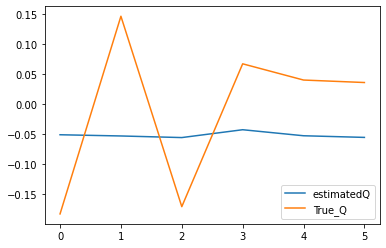